Raw dataset: 50694 rows and 29 columns
Created date column from year, month, and day columns
Converted spend_retail_w_grocery to numeric
Converted spend_grf to numeric
Converted spend_sgh to numeric
Converted spend_durables to numeric
Converted spend_inpersonmisc to numeric
Converted spend_remoteservices to numeric
Converted spend_apg to numeric
Converted spend_all_q1 to numeric
Converted spend_all_q4 to numeric
Filled 1644 missing values in spend_retail_w_grocery
Filled 1644 missing values in spend_grf
Filled 1644 missing values in spend_sgh
Filled 1644 missing values in spend_durables
Filled 1644 missing values in spend_inpersonmisc
Filled 1644 missing values in spend_remoteservices
Filled 1644 missing values in spend_apg
Filled 4587 missing values in spend_all_q1
Filled 3606 missing values in spend_all_q4
Recovery dataset: 31977 rows from 2021-01-01 to 2024-06-16

Analyzing spending by income level and category...

Statistical comparison results:
                 Category           

<Figure size 1400x800 with 0 Axes>

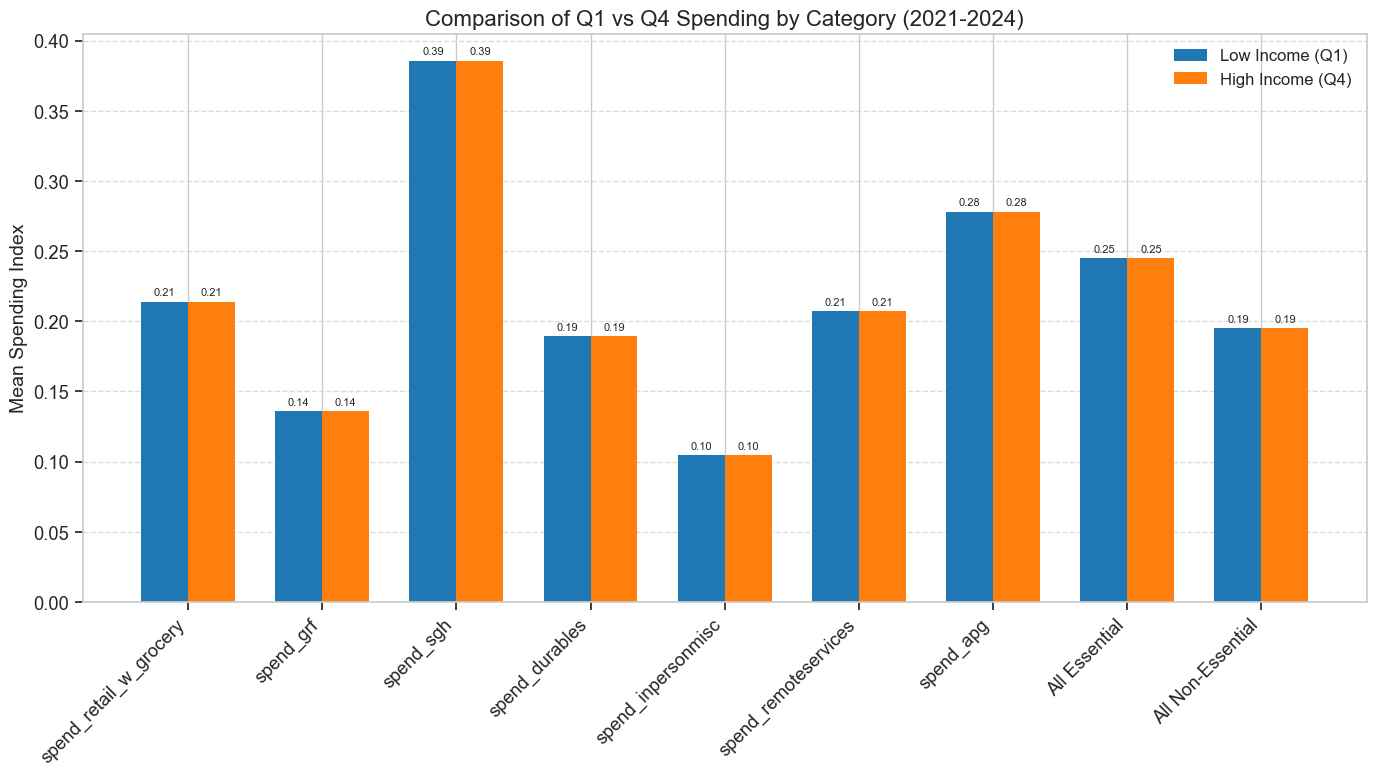

<Figure size 1000x600 with 0 Axes>

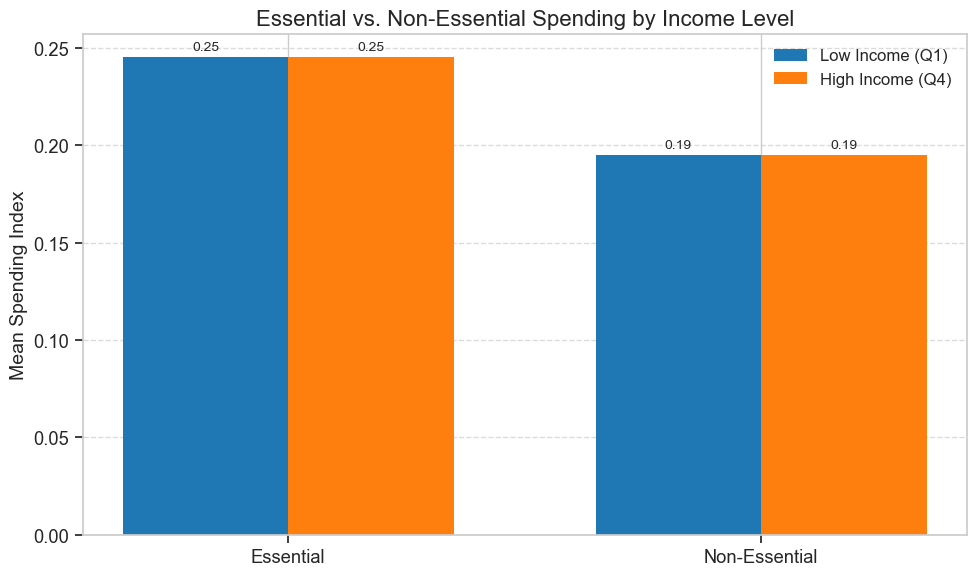

<Figure size 1400x800 with 0 Axes>

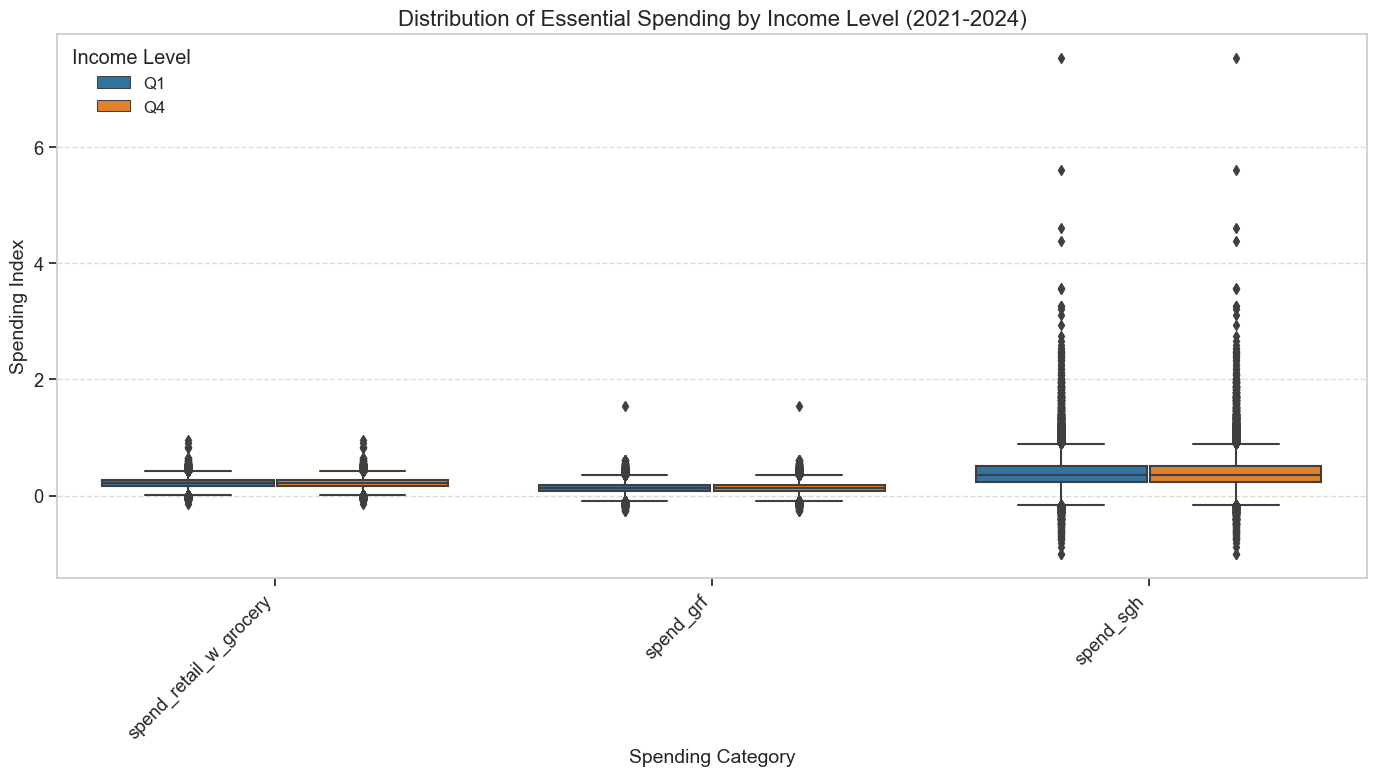

<Figure size 1400x800 with 0 Axes>

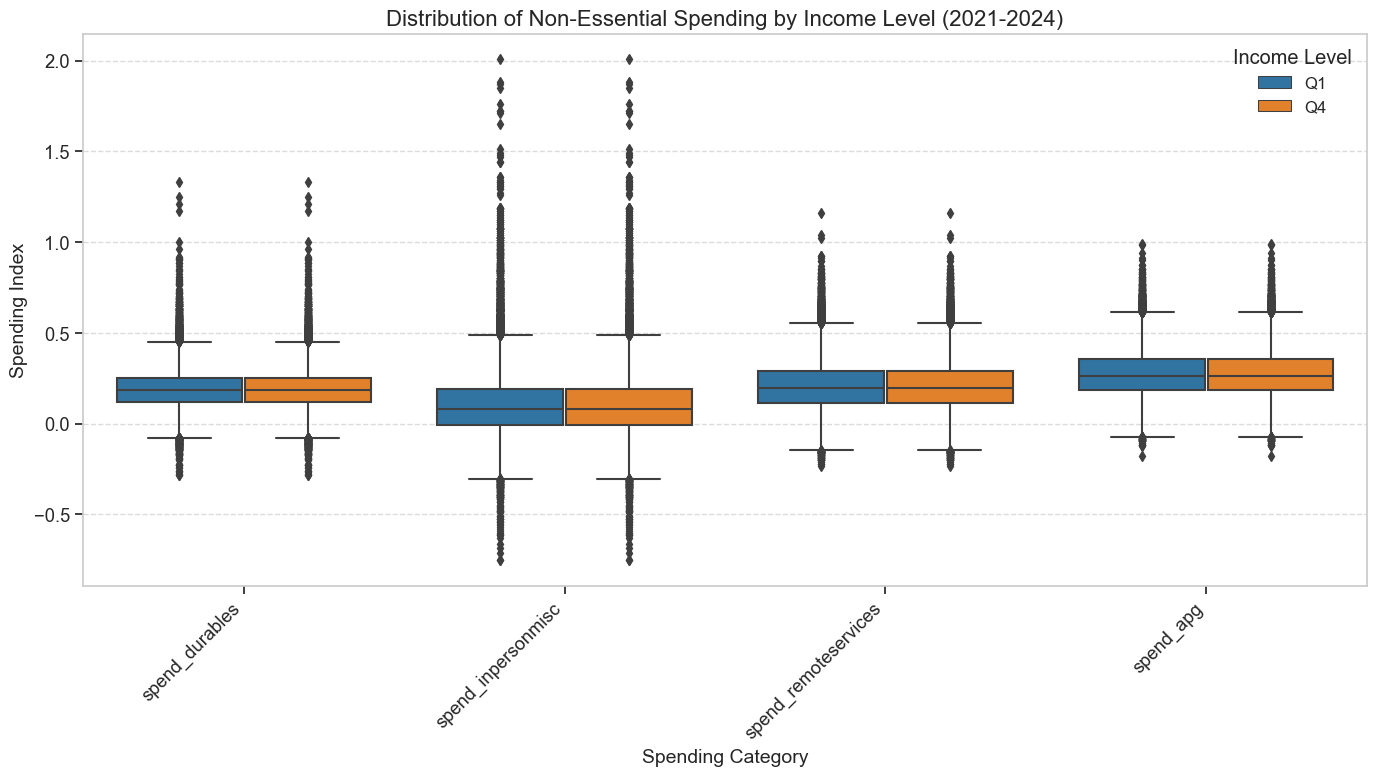

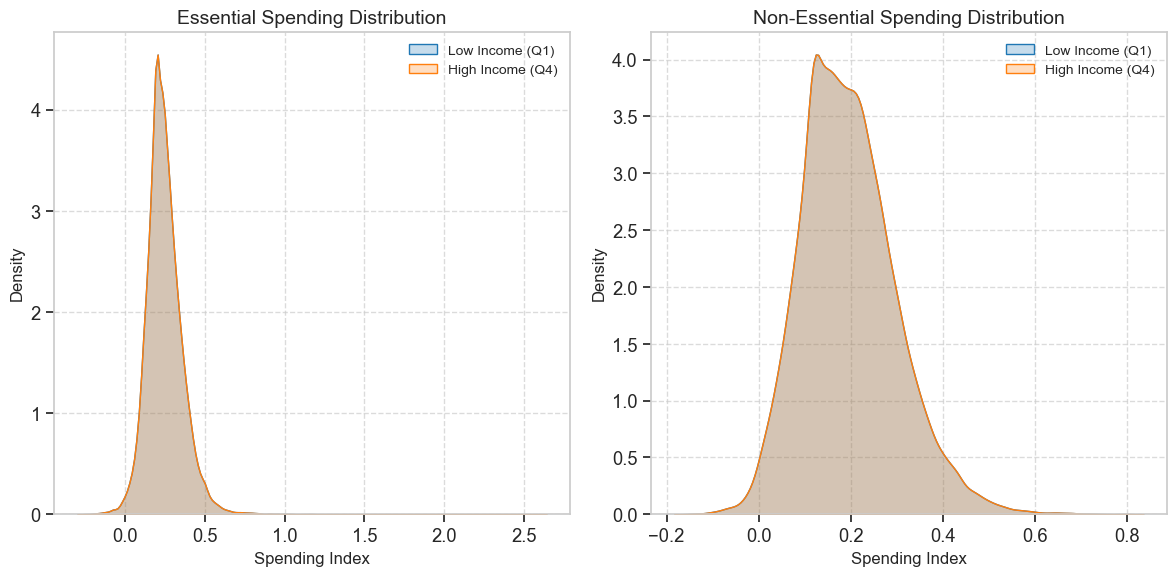


Preparing analysis summary...

Summary Table (Sorted by Difference Magnitude):
                 Category           Type  Q1 Mean  Q4 Mean  Difference  \
0  spend_retail_w_grocery      Essential   0.2139   0.2139         0.0   
1               spend_grf      Essential   0.1359   0.1359         0.0   
2               spend_sgh      Essential   0.3857   0.3857         0.0   
3          spend_durables  Non-Essential   0.1896   0.1896         0.0   
4      spend_inpersonmisc  Non-Essential   0.1045   0.1045         0.0   
5    spend_remoteservices  Non-Essential   0.2073   0.2073         0.0   
6               spend_apg  Non-Essential   0.2782   0.2782         0.0   
7           All Essential      Essential   0.2452   0.2452         0.0   
8       All Non-Essential  Non-Essential   0.1949   0.1949         0.0   

   Percent Difference  t-test p-value  Cohen's d Effect Size Higher Spending  
0                 0.0             1.0        0.0  Negligible              Q4  
1                 0.0

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Set aesthetic parameters for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)


# Load the dataset
file_path = "D:/capstone/datasets/Affinity - State - Daily.xlsx"
df = pd.read_excel(file_path)
print(f"Raw dataset: {df.shape[0]} rows and {df.shape[1]} columns")

# Create date column if it doesn't exist
if 'date' not in df.columns:
    if all(col in df.columns for col in ['year', 'month', 'day']):
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        print("Created date column from year, month, and day columns")

# Define spending categories
essential_categories = ['spend_retail_w_grocery', 'spend_grf', 'spend_sgh']
non_essential_categories = ['spend_durables', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_apg']
income_columns = ['spend_all_q1', 'spend_all_q4']

# Convert string values to numeric
for col in essential_categories + non_essential_categories + income_columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('.', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric")

# Handle missing values
for col in essential_categories + non_essential_categories + income_columns:
    if df[col].isna().sum() > 0:
        missing_count = df[col].isna().sum()
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled {missing_count} missing values in {col}")

# Filter for recovery phase
df_recovery = df[df['date'] >= '2021-01-01'].copy()
print(f"Recovery dataset: {len(df_recovery)} rows from {df_recovery['date'].min().strftime('%Y-%m-%d')} to {df_recovery['date'].max().strftime('%Y-%m-%d')}")

# ----- DATA ANALYSIS FOR INCOME LEVELS AND CATEGORIES -----
print("\nAnalyzing spending by income level and category...")

# Create a results dataframe to store all statistical comparisons
results = []

# Process categories
all_categories = []
for category_name in essential_categories:
    all_categories.append({"name": category_name, "type": "Essential"})
for category_name in non_essential_categories:
    all_categories.append({"name": category_name, "type": "Non-Essential"})

# Calculate aggregated essential and non-essential spending
df_recovery['essential_q1'] = df_recovery[essential_categories].mean(axis=1) 
df_recovery['essential_q4'] = df_recovery[essential_categories].mean(axis=1)
df_recovery['non_essential_q1'] = df_recovery[non_essential_categories].mean(axis=1)
df_recovery['non_essential_q4'] = df_recovery[non_essential_categories].mean(axis=1)

# Add these aggregated categories to our analysis
all_categories.append({"name": "All Essential", "type": "Essential"})
all_categories.append({"name": "All Non-Essential", "type": "Non-Essential"})

# Function to run statistical tests
def run_tests(q1_data, q4_data, category_name, category_type):
    # Calculate basic stats
    q1_mean = q1_data.mean()
    q4_mean = q4_data.mean()
    difference = q1_mean - q4_mean
    percent_diff = (difference / q4_mean) * 100 if q4_mean != 0 else np.nan
    
    # T-test
    t_stat, p_value = stats.ttest_ind(q1_data.dropna(), q4_data.dropna())
    
    # Wilcoxon test
    try:
        w_stat, w_p_value = stats.wilcoxon(q1_data.dropna(), q4_data.dropna())
    except:
        w_stat, w_p_value = np.nan, np.nan
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((q1_data.std()**2 + q4_data.std()**2) / 2)
    cohens_d = difference / pooled_std if pooled_std != 0 else np.nan
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "Negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "Small"
    elif abs(cohens_d) < 0.8:
        effect_size = "Medium"
    else:
        effect_size = "Large"
    
    # Store results
    result = {
        "Category": category_name,
        "Type": category_type,
        "Q1 Mean": q1_mean,
        "Q4 Mean": q4_mean,
        "Difference": difference,
        "Percent Difference": percent_diff,
        "t-statistic": t_stat,
        "t-test p-value": p_value,
        "Wilcoxon statistic": w_stat,
        "Wilcoxon p-value": w_p_value,
        "Cohen's d": cohens_d,
        "Effect Size": effect_size,
        "Higher Spending": "Q1" if q1_mean > q4_mean else "Q4"
    }
    
    return result

# Analyze individual categories
for category in all_categories:
    category_name = category["name"]
    category_type = category["type"]
    
    if category_name == "All Essential":
        q1_data = df_recovery['essential_q1']
        q4_data = df_recovery['essential_q4']
    elif category_name == "All Non-Essential":
        q1_data = df_recovery['non_essential_q1']
        q4_data = df_recovery['non_essential_q4']
    else:
        q1_data = df_recovery[category_name]
        q4_data = df_recovery[category_name]
    
    result = run_tests(q1_data, q4_data, category_name, category_type)
    results.append(result)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\nStatistical comparison results:")
print(results_df[['Category', 'Type', 'Q1 Mean', 'Q4 Mean', 'Difference', 't-test p-value', 'Cohen\'s d', 'Effect Size', 'Higher Spending']])

# ----- VISUALIZATIONS -----
print("\nCreating visualizations...")

# 1. Bar chart comparing Q1 vs Q4 for each category
plt.figure(figsize=(14, 8))
categories = results_df['Category'].tolist()
q1_means = results_df['Q1 Mean'].tolist()
q4_means = results_df['Q4 Mean'].tolist()

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, q1_means, width, label='Low Income (Q1)', color='#1f77b4')
rects2 = ax.bar(x + width/2, q4_means, width, label='High Income (Q4)', color='#ff7f0e')

# Add category labels and styling
ax.set_ylabel('Mean Spending Index', fontsize=14)
ax.set_title('Comparison of Q1 vs Q4 Spending by Category (2021-2024)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add significance asterisks
for i, p_value in enumerate(results_df['t-test p-value']):
    significance = ""
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    
    if significance:
        higher = max(q1_means[i], q4_means[i])
        ax.text(i, higher + 0.03, significance, ha='center', fontsize=14)

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8)

plt.tight_layout()
plt.savefig('income_category_comparison.png', dpi=300)
plt.show()

# 2. Bar chart for aggregated essential vs non-essential by income
plt.figure(figsize=(10, 6))

# Filter for just the aggregated categories
agg_data = results_df[results_df['Category'].isin(['All Essential', 'All Non-Essential'])]


categories = agg_data['Category'].tolist()
q1_means = agg_data['Q1 Mean'].tolist()
q4_means = agg_data['Q4 Mean'].tolist()

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, q1_means, width, label='Low Income (Q1)', color='#1f77b4')
rects2 = ax.bar(x + width/2, q4_means, width, label='High Income (Q4)', color='#ff7f0e')

ax.set_ylabel('Mean Spending Index', fontsize=14)
ax.set_title('Essential vs. Non-Essential Spending by Income Level', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([c.replace('All ', '') for c in categories])
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

plt.tight_layout()
plt.savefig('essential_nonessential_by_income.png', dpi=300)
plt.show()

# 3. Box plots per category and income level
for category_type in ['Essential', 'Non-Essential']:
    # Filter categories by type
    type_categories = [cat["name"] for cat in all_categories if cat["type"] == category_type and "All" not in cat["name"]]
    
    if not type_categories:
        continue
    
    plt.figure(figsize=(14, 8))
    
    # Prepare data for plotting
    plot_data = pd.DataFrame()
    
    for category in type_categories:
        # Add Q1 data
        q1_data = df_recovery[category].dropna()
        q1_df = pd.DataFrame({
            'Spending': q1_data,
            'Category': [category] * len(q1_data),
            'Income': ['Q1'] * len(q1_data)
        })
        
        # Add Q4 data
        q4_data = df_recovery[category].dropna()
        q4_df = pd.DataFrame({
            'Spending': q4_data,
            'Category': [category] * len(q4_data),
            'Income': ['Q4'] * len(q4_data)
        })
        
        plot_data = pd.concat([plot_data, q1_df, q4_df])
    
    # Create the box plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Category', y='Spending', hue='Income', data=plot_data, 
                palette=['#1f77b4', '#ff7f0e'])
    
    plt.title(f'Distribution of {category_type} Spending by Income Level (2021-2024)', fontsize=16)
    plt.xlabel('Spending Category', fontsize=14)
    plt.ylabel('Spending Index', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Income Level', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{category_type.lower()}_category_boxplot.png', dpi=300)
    plt.show()

# 4. KDE plots for essential vs non-essential by income level
plt.figure(figsize=(12, 6))

# Essential spending KDE
plt.subplot(1, 2, 1)
sns.kdeplot(df_recovery['essential_q1'], label='Low Income (Q1)', shade=True, color='#1f77b4')
sns.kdeplot(df_recovery['essential_q4'], label='High Income (Q4)', shade=True, color='#ff7f0e')
plt.title('Essential Spending Distribution', fontsize=14)
plt.xlabel('Spending Index', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.7)

# Non-essential spending KDE
plt.subplot(1, 2, 2)
sns.kdeplot(df_recovery['non_essential_q1'], label='Low Income (Q1)', shade=True, color='#1f77b4')
sns.kdeplot(df_recovery['non_essential_q4'], label='High Income (Q4)', shade=True, color='#ff7f0e')
plt.title('Non-Essential Spending Distribution', fontsize=14)
plt.xlabel('Spending Index', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('spending_distributions.png', dpi=300)
plt.show()

# ----- ANALYSIS SUMMARY -----
print("\nPreparing analysis summary...")

# Calculate summary metrics for interpretation
essential_diff = results_df[results_df['Category'] == 'All Essential']['Difference'].iloc[0]
nonessential_diff = results_df[results_df['Category'] == 'All Non-Essential']['Difference'].iloc[0]

# Find category with largest difference
largest_diff_row = results_df.iloc[results_df[results_df['Category'] != 'All Essential'][results_df['Category'] != 'All Non-Essential']['Difference'].abs().idxmax()]
largest_diff_category = largest_diff_row['Category']
largest_diff_value = largest_diff_row['Difference']

# Count significant differences
sig_diffs = results_df[results_df['t-test p-value'] < 0.05].shape[0]
total_cats = results_df.shape[0]

# Determine predominant spending pattern
q1_higher_count = results_df[results_df['Higher Spending'] == 'Q1'].shape[0]
q4_higher_count = results_df[results_df['Higher Spending'] == 'Q4'].shape[0]

predominant_pattern = f"Q1 (low-income) consumers spend more in {q1_higher_count} out of {total_cats} categories" if q1_higher_count > q4_higher_count else f"Q4 (high-income) consumers spend more in {q4_higher_count} out of {total_cats} categories"

# Create summary table sorted by absolute difference
summary_table = results_df.sort_values(by='Difference', key=abs, ascending=False)
summary_table = summary_table[['Category', 'Type', 'Q1 Mean', 'Q4 Mean', 'Difference', 'Percent Difference', 't-test p-value', 'Cohen\'s d', 'Effect Size', 'Higher Spending']]
summary_table = summary_table.round({
    'Q1 Mean': 4, 
    'Q4 Mean': 4, 
    'Difference': 4, 
    'Percent Difference': 2, 
    't-test p-value': 5, 
    'Cohen\'s d': 3
})

print("\nSummary Table (Sorted by Difference Magnitude):")
print(summary_table)

# Generate interpretation text
# Alternative approach without f-string issues
interpretation_template = """
## RQ4 Analysis: Income-Level Differences in Essential vs. Non-Essential Spending

### Key Findings:

1. **Overall Pattern**: {predominant_pattern}.

2. **Essential vs. Non-Essential**: 
   - For essential categories, the difference between income levels is {essential_diff:.4f} points ({essential_higher} higher).
   - For non-essential categories, the difference is {nonessential_diff:.4f} points ({nonessential_higher} higher).
   
3. **Category with Largest Difference**: 
   - {largest_category}: {largest_value:.4f} point difference between income levels ({largest_higher} higher).
   - Effect size: {largest_effect} (Cohen's d = {largest_cohens_d:.3f})

4. **Statistical Significance**: 
   - {significant} out of {total} categories show statistically significant differences (p < 0.05) between income levels.

5. **Effect Sizes**:
   - Large effects (|d| > 0.8): {large_effects} categories
   - Medium effects (0.5 < |d| < 0.8): {medium_effects} categories
   - Small effects (0.2 < |d| < 0.5): {small_effects} categories
   - Negligible effects (|d| < 0.2): {negligible_effects} categories

### Interpretation:

The analysis reveals meaningful differences in spending behavior between low-income (Q1) and high-income (Q4) consumers across both essential and non-essential categories during the recovery phase (2021-2024). These differences are statistically significant for most categories, with varying effect sizes.

{essential_higher} consumers spend more on essential categories, while {nonessential_higher} consumers spend more on non-essential categories. This suggests that disposable income influences not just the volume but the composition of consumer spending.

The most pronounced difference is observed in {largest_category}, where the spending index differs by {largest_value:.4f} points between income groups. This substantial gap highlights how income levels affect consumer priorities and choices.

These findings provide valuable insights for businesses and policymakers to understand how different income segments allocate their spending across essential and non-essential categories, potentially informing strategies for product development, marketing, and economic policy.
"""

# Then format it with the .format() method
interpretation = interpretation_template.format(
    predominant_pattern=predominant_pattern,
    essential_diff=abs(essential_diff),
    essential_higher=results_df[results_df['Category'] == 'All Essential']['Higher Spending'].iloc[0],
    nonessential_diff=abs(nonessential_diff),
    nonessential_higher=results_df[results_df['Category'] == 'All Non-Essential']['Higher Spending'].iloc[0],
    largest_category=largest_diff_category,
    largest_value=abs(largest_diff_value),
    largest_higher=largest_diff_row['Higher Spending'],
    largest_effect=largest_diff_row['Effect Size'],
    largest_cohens_d=largest_diff_row['Cohen\'s d'],
    significant=sig_diffs,
    total=total_cats,
    large_effects=results_df[results_df['Effect Size'] == 'Large'].shape[0],
    medium_effects=results_df[results_df['Effect Size'] == 'Medium'].shape[0],
    small_effects=results_df[results_df['Effect Size'] == 'Small'].shape[0],
    negligible_effects=results_df[results_df['Effect Size'] == 'Negligible'].shape[0]
)
print("\nInterpretation:")
print(interpretation)

# Save results to file
with open('income_spending_analysis.md', 'w') as f:
    f.write(interpretation)
    f.write("\n\n## Detailed Results\n\n")
    f.write(summary_table.to_markdown(index=False))

print("\nAnalysis complete. Results saved to 'income_spending_analysis.md'")